# 10. 피부암 초기 진단

*   이미지 데이터와 정형 데이터 병합 및 전처리 방법을 이해한다.
*   이미지 학습 알고리즘 CNN에 대해 더 깊게 이해한다.
*   심화 수준의 이미지 학습 인공지능 모델을 제작한다.



# 학습률 개선과 조기 종료




*   좀 더 정교한 인공지능을 만들기 위한 두 가지 함수를 짚고 넘어가고자 한다. 바로 ‘**학습률 개선(ReduceLROnPlateau)’**과  **‘조기 종료(EarlyStopping)'** 이다.


---


*   **학습률 개선**: 지역 최소화 문제(극소점,Local Minima)에 빠져 있을 경우 Learning Rate(학습률)를 조절하여 다른 곳까지 탐색할 수 있게 하는 함수
*   **조기종료**: 이미 최소의 loss 값인 지점(Global Minima)에 도달해 놓고도 학습 횟수(ephochs)가 남을 경우 학습을 중단하게 하는 함수
 
 



#피부암 데이터셋 불러오기

피부암 이미지를 모아둔 데이터 세트를 캐글(kaggle) API를 활용하여 불러오자. 



*   API 업로드 참고자료 : https://teddylee777.github.io/kaggle/Kaggle-API-%EC%82%AC%EC%9A%A9%EB%B2%95/

In [ ]:
!pip install kaggle

from google.colab import files
files.upload()
#kaggle api 업로드하기

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip /content/skin-cancer-mnist-ham10000.zip

# 데이터가 많아서 시간이 오래 걸리며 런타임 종류를 None으로 하는 것을 추천

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_

glob( )함수를 이용하여 데이터 세트를 묶어 **image_lis**t에 경로를 저장한다. 

경로명을 가져오는 **basename( )함수**로 파일명과 파일 위치 딕셔너리를 만든다



In [ ]:
import numpy as np
import pandas as pd
import io
import os
from glob import glob

In [ ]:
image_list = glob(os.path.join('/content/HAM10000_images_part_1/','*.jpg'))
image_list = image_list + glob(os.path.join('/content/HAM10000_images_part_2/','*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in image_list}

imageid_path_dict

# 데이터가 많아 실행시간이 오래걸리니, 주의하자

{'ISIC_0025078': '/content/HAM10000_images_part_1/ISIC_0025078.jpg',
 'ISIC_0026727': '/content/HAM10000_images_part_1/ISIC_0026727.jpg',
 'ISIC_0024548': '/content/HAM10000_images_part_1/ISIC_0024548.jpg',
 'ISIC_0029062': '/content/HAM10000_images_part_1/ISIC_0029062.jpg',
 'ISIC_0028501': '/content/HAM10000_images_part_1/ISIC_0028501.jpg',
 'ISIC_0027056': '/content/HAM10000_images_part_1/ISIC_0027056.jpg',
 'ISIC_0026012': '/content/HAM10000_images_part_1/ISIC_0026012.jpg',
 'ISIC_0024675': '/content/HAM10000_images_part_1/ISIC_0024675.jpg',
 'ISIC_0024667': '/content/HAM10000_images_part_1/ISIC_0024667.jpg',
 'ISIC_0026532': '/content/HAM10000_images_part_1/ISIC_0026532.jpg',
 'ISIC_0027835': '/content/HAM10000_images_part_1/ISIC_0027835.jpg',
 'ISIC_0026847': '/content/HAM10000_images_part_1/ISIC_0026847.jpg',
 'ISIC_0028680': '/content/HAM10000_images_part_1/ISIC_0028680.jpg',
 'ISIC_0027252': '/content/HAM10000_images_part_1/ISIC_0027252.jpg',
 'ISIC_0024493': '/content/HAM1000

# 메타 데이터 전처리하기

*   **메타(Meta) 데이터** : 데이터의 정보를 저장하는 데이터

피부암 메타 데이터 파일(HAM10000_metadata.csv)을 불러와 데이터를 확인한다.




In [ ]:
data = pd.read_csv('/content/HAM10000_metadata.csv')
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


메타 데이터에 추가 정보를 덧붙여 데이터의 이해를 높인다.

**map( )함수**로 병명 딕셔너리와 이미지 경로 딕셔너리를 매칭시킨다.

In [ ]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,male,back
freq,6,1,6705,5340,5406,2192


나이(age)데이터 중 1개에 NaN 값을 평균값으로 처리

In [ ]:
data.isna().any()

lesion_id       False
image_id        False
dx              False
dx_type         False
age              True
sex             False
localization    False
dtype: bool

In [ ]:
data.isna().any().sum()

1

In [ ]:
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
data['age'] = data['age'].astype('int32')

메타 데이터에 추가 정보를 덧붙여 데이터의 이해를 높인다.

**map( )함수**로 병명 딕셔너리와 이미지 경로 딕셔너리를 **매칭**시킨다.

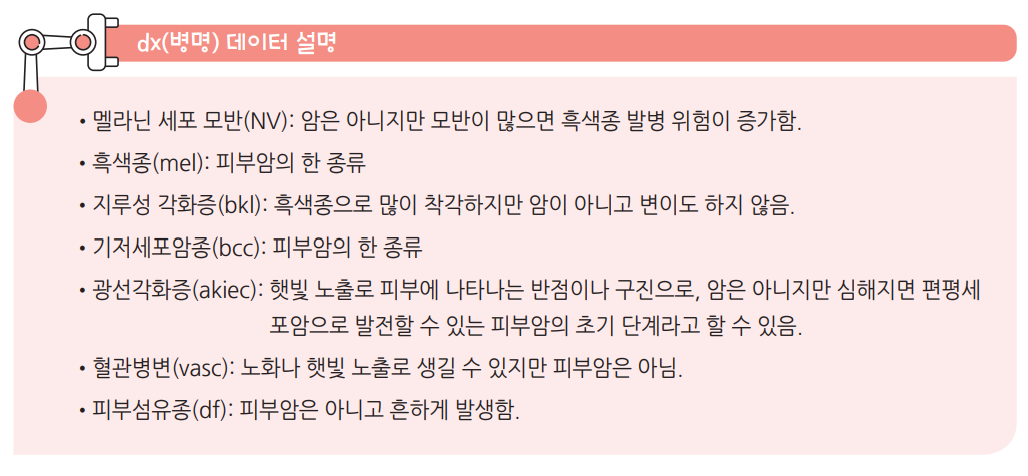

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}

In [ ]:
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [ ]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_2/ISIC_0031633.jpg


# 이미지 데이터 시각화하기

1.   이미지 처리와 시각화에 필요한 모듈을 불러오고 **람다식을 실행**한다.
2.   이미지를 불러와서 **적합한 크기**(28, 28)로 **변환**한다.
3.   **‘image_pixel’**이라는 열(Column)을 생성하여 변환된 이미지를 저장한다 




In [ ]:
from PIL import Image
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [ ]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0027419.jpg,"[[[192, 153, 193], [195, 155, 192], [197, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0025030.jpg,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0026769.jpg,"[[[192, 138, 153], [200, 144, 162], [202, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_1/ISIC_0025661.jpg,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),/content/HAM10000_images_part_2/ISIC_0031633.jpg,"[[[159, 114, 140], [194, 144, 173], [215, 162,..."


실제 피부암 데이터를 시각화해서 살펴보기 위해 병명당 두 개씩 이미지 데이터를 추출해보자.


1.   데이터를 **병명(dx)**으로 **그룹화(groupby)**해준다
2.   각 병명 데이터 중 **0번과 1번에 저장된 데이터**의 **9번열**(image_pixel) 과 **7번열**(cell_type)을 불러와 sample_data에 저장한다.







In [ ]:
sample_data = data.groupby('dx').apply(lambda df: df.iloc[0:2, [9, 7]])
sample_data

image_pixel  \
dx                                                              
akiec 9687  [[[30, 14, 19], [37, 21, 28], [94, 69, 73], [1...   
      9688  [[[38, 22, 22], [87, 67, 66], [135, 112, 110],...   
bcc   2462  [[[16, 11, 12], [58, 46, 48], [177, 153, 149],...   
      2463  [[[197, 177, 198], [202, 188, 205], [207, 194,...   
bkl   0     [[[192, 153, 193], [195, 155, 192], [197, 154,...   
      1     [[[27, 16, 32], [69, 49, 76], [122, 93, 126], ...   
df    1095  [[[173, 132, 123], [195, 151, 144], [204, 162,...   
      1096  [[[220, 172, 180], [229, 180, 179], [240, 192,...   
mel   1211  [[[151, 126, 129], [161, 132, 138], [168, 140,...   
      1212  [[[201, 172, 187], [201, 173, 188], [203, 178,...   
nv    64    [[[163, 135, 159], [167, 140, 167], [170, 144,...   
      1210  [[[229, 145, 164], [229, 138, 162], [226, 133,...   
vasc  2320  [[[218, 189, 211], [221, 192, 214], [223, 190,...   
      2321  [[[162, 132, 132], [173, 142, 147], [180, 150,...   

                                      cell_type  
dx                                               
akiec 9687            Actinic keratoses (akiec)  
      9688            Actinic keratoses (akiec)  
bcc   2462           Basal cell carcinoma (bcc)  
      2463           Basal cell carcinoma (bcc)  
bkl   0     Benign keratosis-like lesions (bkl)  
      1     Benign keratosis-like lesions (bkl)  
df    1095                  Dermatofibroma (df)  
      1096                  Dermatofibroma (df)  
mel   1211                       Melanoma (mel)  
      1212                       Melanoma (mel)  
nv    64                  Melanocytic nevi (nv)  
      1210                Melanocytic nevi (nv)  
vasc  2320              Vascular lesions (vasc)  
      2321              Vascular lesions (vasc)

*   **반복문**으로 14개의 이미지를 시각화한다.
     - 7가지 피부질환 X 이미지 2장 씩
*   **subplot(  )**으로 적절한 크기로 각각 그래프 그리기
*   **imshow(  )**로 14개의 작은 subplot에 이미지를 시각화
*   이미지 제목(title)에 **병명을 적어주기**
*   **axis(“off”)** 설정으로 그래프 축을 제거

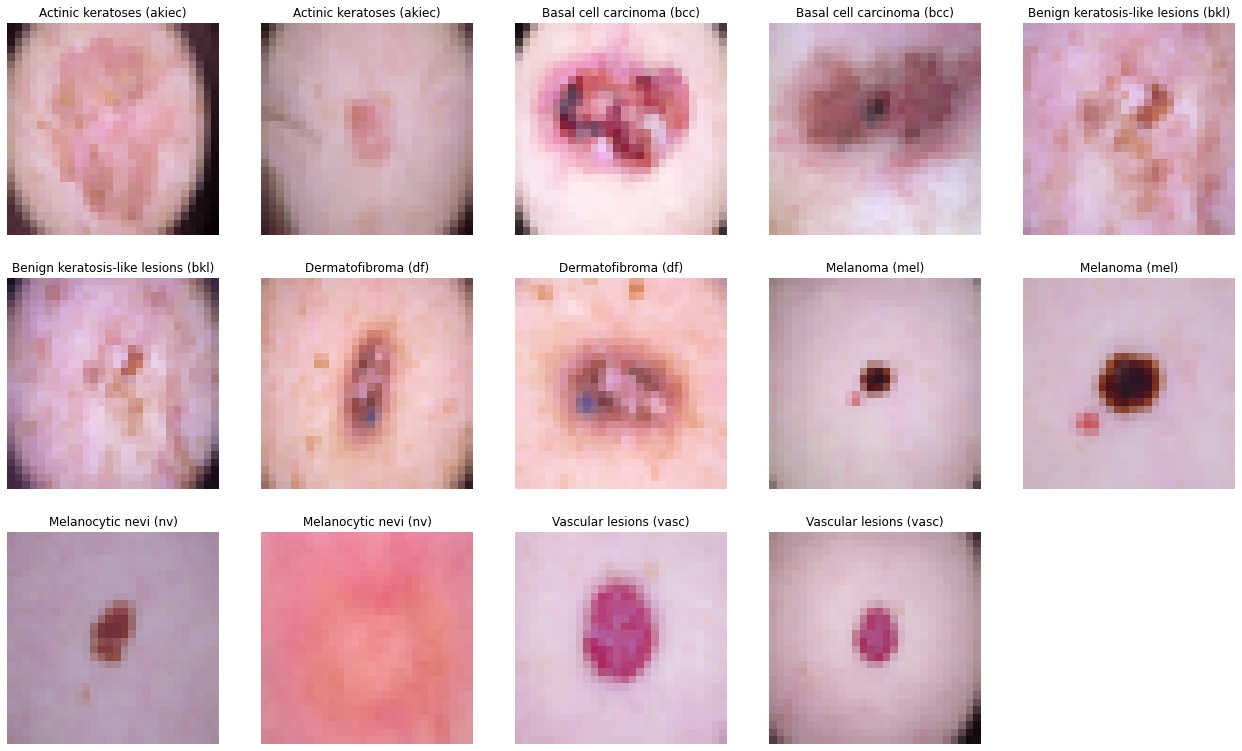

In [ ]:
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    plt.title(sample_data['cell_type'][i])
    plt.axis("off")
plt.show();

# 이미지 데이터 전처리하기

*  카테고리 문자형 병명 데이터를 0~6까지 숫자로 라벨링을 한다
*  라벨링 숫자와 병명 딕셔너리를 만들고 매핑해 준다.

---

*  ‘label’이라는 열(Column)을 생성
*  ‘label’을 기준으로 정렬 및 index를 초기화해 준다.


In [ ]:
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [ ]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

라벨링으로 그룹화해 막대그래프와 개수를 출력해보자

*   멜라닌 세포 모반(NV) 데이터가 2/3

**불균형이 발생한 데이터**로 학습한 인공지능은 개수가 많은 데이터로 정답을 내는 경향이 있다
*   정답일 확률이 높다 VS **많은 것으로 찍는다**

➡ **데이터 전처리**를 통해 해결해야 한다 

label
0    6705
1    1113
2    1099
3     514
4     327
5     142
6     115
Name: index, dtype: int64


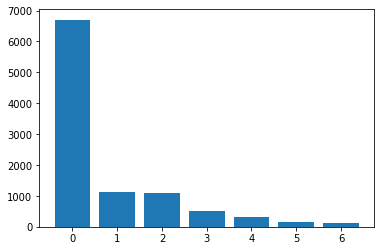

In [ ]:
plt.bar([0,1,2,3,4,5,6], data.groupby('label')['index'].count())
print(data.groupby('label')['index'].count())



*   해결방법 : 데이터를 복제해서 수를 비슷하게 맞춘다.
    * 이미지 데이터를 복사해 ‘frames’에 추가
    * ‘frames’를 concat(  )로 합친 후‘final_data’에 저장

*   4만 5,756개의 피부질환 이미지 데이터가 균형 있게 존재한다.



In [ ]:
counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)

In [ ]:
final_data = pd.concat(frames)

print(data.shape)
print(final_data.shape)

(10015, 12)
(45756, 12)


label
0    6705
1    6678
2    6594
3    6682
4    6213
5    6674
6    6210
Name: index, dtype: int64


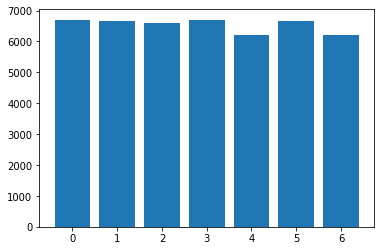

In [ ]:
plt.bar([0,1,2,3,4,5,6], final_data.groupby('label')['index'].count())
print(final_data.groupby('label')['index'].count())



*   ‘image_pixel’을 넘파이 형식으로 변환하여 독립 변수(X_aug)에 저장.

*   라벨링된 병명을 종속 변수(Y_aug)에 저장.



In [ ]:
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


#CNN 이미지 학습

*   이미지 데이터를 학습하기 위해 필요한 여러 모듈을 불러온다 
*   훈련 데이터와 테스트 데이터를 8:2 비율로 나눈 후   **이미지 학습 데이터**를 생성한다(*ImageDataGenerator*)
     * 정확도를 높이기 위해 이미지를 변환하여 데이터를 증식




In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
tf.random.set_seed(3)
X_train, X_test, Y_train, Y_test = train_test_split(X_aug, Y_aug, test_size=0.2, random_state=3)
    
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
train_datagen.fit(X_train)

*   테스트 데이터에 **정규화 작업**을 한다.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen.fit(X_test)

*   CNN 모델 생성 함수를 정의한다.
    * Conv2D, MaxPool2D

*   앞 Unit과 다른 점
padding을 ‘same’으로 설정 
    * 이유 : 이미지 형태가  변환되는 것을  막기 위해
*   sparse_categorical_crossentropy(  )로  손실 함수를 계산


In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;



*   CNN 모델 학습 함수를 생성한다.
*   **조기 종료와 학습률 개선**을 설정해 준다
 -  **patience:** 검증 데이터의 오차(val_loss)를 학습 
 중단 기준으로 몇 번 기다려 줄지 설정
 -  **verbose=1** : 매번 결과 정보를 출력




In [ ]:
def train_model(model, X_train, Y_train, EPOCHS):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
    
    history = model.fit(X_train, Y_train, validation_split=0.2, batch_size = 64, epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

CNN 모델 학습 결과를 **시각화 함수**를 생성한다.
 

*   첫 번째 그래프(row=1, col=1)에는 *훈련 데이터 와 검증 데이터*의 정확도 
*   두 번째 그래프(row=1, col=2)에는 *오차*를 출력




In [ ]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], name='train_acc'), row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], name='val_acc'), row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], name='train_loss'), row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], name='val_loss'), row=1, col=2)
    fig.show()

**k-fold를 생성**하고 **CNN 모델을 생성**한다.

   * 교차 검증 1회당 50번의 학습(epochs)을 진행한다.


In [ ]:
num_folds = 5
acc_per_fold=[]
loss_per_fold=[]
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
fold_no=1
epochs = 50
model=create_model()

kfold.split() 함수로 훈련 데이터로 **교차 검증**하면서 학습하고 **학습 결과를 시각화**한다.


*   첫 번째 교차 검증
   * 4번의 학습 개선과 30번째 학습에서 조기 종료가 발생

   * 학습을 거듭할수록 좋아지다가 15번째 이후로 수준이 비슷해 짐.
*   다섯 번째 교차 검증
   * 99% 이상의 정확도와 0.1 미만의 오차에서 학습을 종료



In [ ]:
for train,test in kfold.split(X_train, Y_train):
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  history = train_model(model, X_train[train], Y_train[train],EPOCHS=epochs)
  plot_model_training_curve(history)

  scores = model.evaluate(X_train[test], Y_train[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  model_file='skin_caner_5folds_'+str(fold_no)+'.h5'
  model.save(model_file)
  
  fold_no = fold_no + 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

Score for fold 1: loss of 0.12861879169940948; accuracy of 97.40472435951233%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0322 - accuracy: 0.9936 - val_loss: 0.1142 - val_accuracy: 0.9747 - lr: 1.0000e-07
Epoch 2/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0314 - accuracy: 0.9936 - val_loss: 0.1120 - val_accuracy: 0.9754 - lr: 1.0000e-07
Epoch 3/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0309 - accuracy: 0.9936 - val_loss: 0.1102 - val_accuracy: 0.9761 - lr: 1.0000e-07
Epoch 4/50
367/367 [==============================] - 2s 4ms/step - loss: 0.0304 - accuracy: 0.9938 - val_loss: 0.1087 - val_accuracy: 0.9768 - lr: 1.0000e-07
Epoch 5/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0301 - accuracy: 0.9938 - val_loss: 0.1073 - val_accuracy: 0.9773 - lr: 1.0000e-07
Epoch 6/50
367/367 [==========

Score for fold 2: loss of 0.019054163247346878; accuracy of 99.60387945175171%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0237 - accuracy: 0.9950 - val_loss: 0.0907 - val_accuracy: 0.9805 - lr: 1.0000e-07
Epoch 2/50
367/367 [==============================] - 2s 4ms/step - loss: 0.0236 - accuracy: 0.9950 - val_loss: 0.0905 - val_accuracy: 0.9805 - lr: 1.0000e-07
Epoch 3/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0236 - accuracy: 0.9950 - val_loss: 0.0904 - val_accuracy: 0.9805 - lr: 1.0000e-07
Epoch 4/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0235 - accuracy: 0.9950 - val_loss: 0.0903 - val_accuracy: 0.9805 - lr: 1.0000e-07
Epoch 5/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0235 - accuracy: 0.9950 - val_loss: 0.0901 - val_accuracy: 0.9805 - lr: 1.0000e-07
Epoch 6/50
367/367 [=========

Score for fold 3: loss of 0.012154491618275642; accuracy of 99.75413084030151%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0212 - accuracy: 0.9956 - val_loss: 0.0785 - val_accuracy: 0.9829 - lr: 1.0000e-07
Epoch 2/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0212 - accuracy: 0.9956 - val_loss: 0.0784 - val_accuracy: 0.9829 - lr: 1.0000e-07
Epoch 3/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0211 - accuracy: 0.9956 - val_loss: 0.0783 - val_accuracy: 0.9829 - lr: 1.0000e-07
Epoch 4/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0211 - accuracy: 0.9956 - val_loss: 0.0782 - val_accuracy: 0.9829 - lr: 1.0000e-07
Epoch 5/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0211 - accuracy: 0.9956 - val_loss: 0.0781 - val_accuracy: 0.9829 - lr: 1.0000e-07
Epoch 6/50
367/367 [=========

Score for fold 4: loss of 0.01810925081372261; accuracy of 99.61754083633423%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0194 - accuracy: 0.9959 - val_loss: 0.0713 - val_accuracy: 0.9829 - lr: 1.0000e-07
Epoch 2/50
367/367 [==============================] - 2s 5ms/step - loss: 0.0194 - accuracy: 0.9959 - val_loss: 0.0712 - val_accuracy: 0.9829 - lr: 1.0000e-07
Epoch 3/50
367/367 [==============================] - 2s 4ms/step - loss: 0.0194 - accuracy: 0.9959 - val_loss: 0.0712 - val_accuracy: 0.9834 - lr: 1.0000e-07
Epoch 4/50
367/367 [==============================] - 2s 4ms/step - loss: 0.0193 - accuracy: 0.9959 - val_loss: 0.0712 - val_accuracy: 0.9834 - lr: 1.0000e-07
Epoch 5/50
367/367 [==============================] - 2s 4ms/step - loss: 0.0193 - accuracy: 0.9959 - val_loss: 0.0712 - val_accuracy: 0.9834 - lr: 1.0000e-07
Epoch 6/50
367/367 [==========

Score for fold 5: loss of 0.019912485033273697; accuracy of 99.64480996131897%


In [ ]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.12861879169940948 - Accuracy: 97.40472435951233%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.019054163247346878 - Accuracy: 99.60387945175171%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.012154491618275642 - Accuracy: 99.75413084030151%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.01810925081372261 - Accuracy: 99.61754083633423%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.019912485033273697 - Accuracy: 99.64480996131897%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 99.20501708984375 (+- 0.9016944738426325)
> Loss: 0.03956983648240566
-------------------

# CNN 모델 테스트하기


CNN 모델을 테스트 데이터에 적용하고 평가해보자.
 

*   evaluate( )로 테스트한 결과 98.328%라는 높은 정확도를 보임.




In [ ]:
model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 98.328%


predict(  ) 함수로 예측한 값(y_pred)과 실제 값(Y_test)을 바탕으로 병명마다 정확도를 비교한다.


In [ ]:
y_true = np.array(Y_test)
y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
print(clr)

286/286 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

          nv       0.99      0.90      0.94      1373
         mel       0.95      0.99      0.97      1334
         bkl       0.96      0.99      0.98      1324
         bcc       0.99      1.00      1.00      1352
       akiec       1.00      1.00      1.00      1232
        vasc       1.00      1.00      1.00      1299
          df       1.00      1.00      1.00      1238

    accuracy                           0.98      9152
   macro avg       0.98      0.98      0.98      9152
weighted avg       0.98      0.98      0.98      9152



1/1 [==============================] - 0s 17ms/step


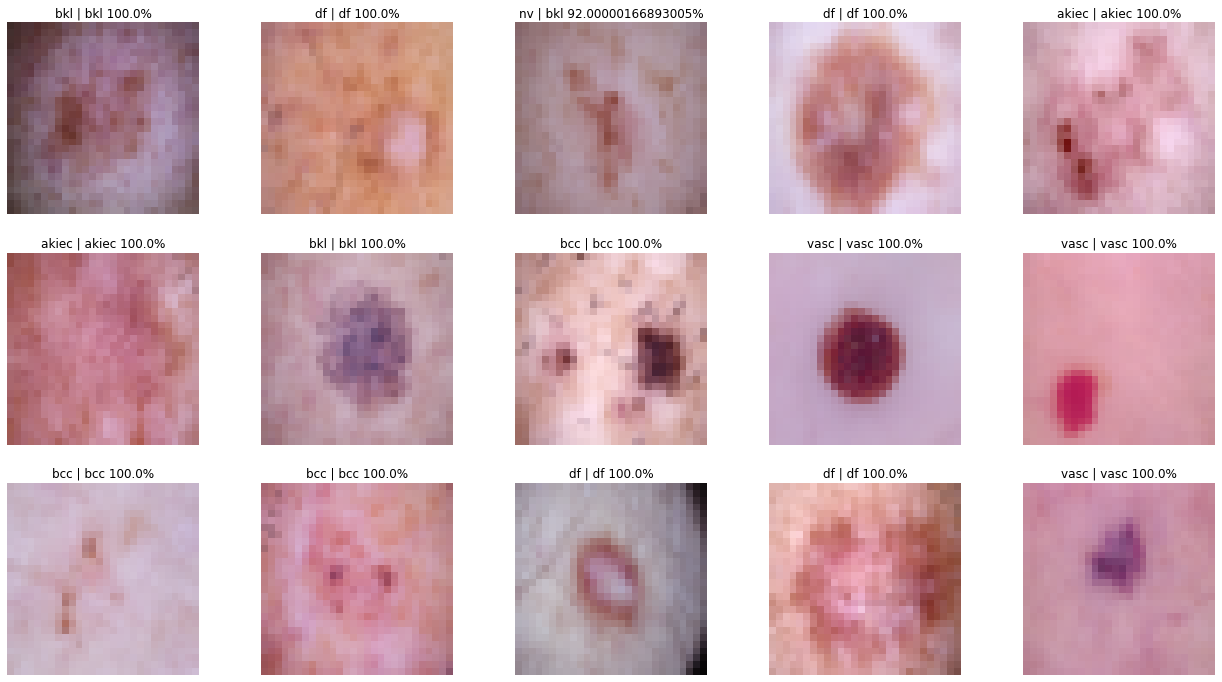

In [ ]:
sample_data = X_test[:15]
prediction = model.predict(sample_data)

plt.figure(figsize=(22, 12))
for i in range(15):
  plt.subplot(3, 5, i + 1)
  plt.imshow(sample_data[i])
  prediction_probability = np.amax(prediction[i]).round(2)
  plt.title(label_mapping[y_true[i][0]] + ' | ' + label_mapping[y_pred[i]] + ' ' + str(prediction_probability*100)+ '%' )
  plt.axis("off")
plt.show()

혼동 행렬 함수에 학습한 CNN 정보를 넣으면 피부질환을 분류결과를 혼동 행렬로 표현할 수 있다.

*   ‘cmap’이라는 기능을 통해 데이터 값에 맞춰 색 조합이 가능

*    itertools(파이썬 라이브러리) 모듈을 사용하여, 혼동 행렬을 시각적으로 매력 있게 표현 가능



In [ ]:
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes, name, normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

In [ ]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name, y_true,y_pred):

    y_predict_classes, y_true_classes = y_pred, y_true
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

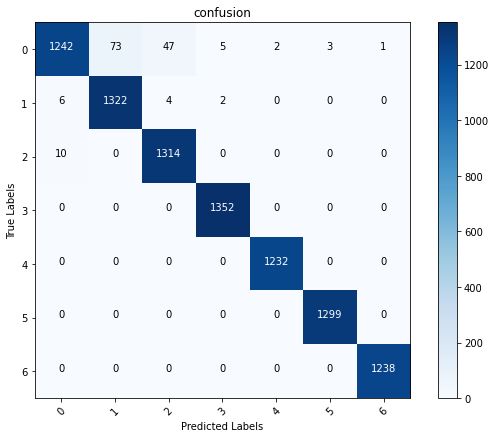

In [ ]:
create_confusion_matrix(model, X_test, Y_test, label_mapping, 'confusion', y_true, y_pred)

# 더 알아보기

팬의 조언에 따라 가슴의 점을 제거한 수영 선수 맥 호턴(Mack Horton)

➡ **우리가 제작한 CNN 이미지 분류 모델로 테스트를 해서 병명을 알아보는 건 어떨까?**

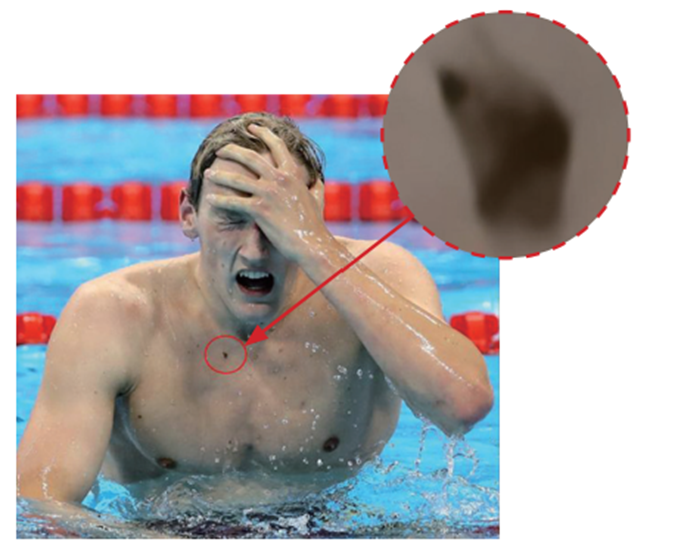

In [ ]:
files.upload()

Saving Mack_Horton_Skin.jpg to Mack_Horton_Skin (2).jpg


{'Mack_Horton_Skin.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\x90\x00\x90\x00\x00\xff\xe1\x10\xdcExif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x04\x01;\x00\x02\x00\x00\x00\n\x00\x00\x08J\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x08T\x9c\x9d\x00\x01\x00\x00\x00\x08\x00\x00\x10\xcc\xea\x1c\x00\x07\x00\x00\x08\x0c\x00\x00\x00>\x00\x00\x00\x00\x1c\xea\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

테스트 결과, **멜라닌 세포 모반(NV)**으로 예측하는 것을 확인 할 수 있다.

1/1 [==============================] - 0s 167ms/step


(-0.5, 327.5, 350.5, -0.5)

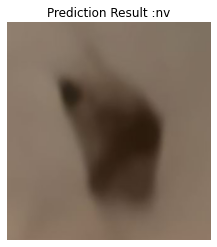

In [ ]:
test_img = image.load_img('/content/Mack_Horton_Skin.jpg', target_size=((28,28)))
test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)
prediction = model.predict(test_img)
prediction_idx = np.argmax(prediction)
test_image = plt.imread('/content/Mack_Horton_Skin.jpg')
plt.imshow(test_image)
plt.title('Prediction Result :' + label_mapping[prediction_idx])
plt.axis("off")

In [ ]:
print('===============================')
print('prediction per disease')
print('===============================')
for i in range(7):
  print(f'> {label_mapping[i]} : {(prediction[0][i]*100).round(2)} %')
print('===============================')

prediction per disease
> nv : 99.91 %
> mel : 0.09 %
> bkl : 0.0 %
> bcc : 0.0 %
> akiec : 0.0 %
> vasc : 0.0 %
> df : 0.0 %
